In [2]:
# Copyright (C) 2024 Richard Stiskalek
# This program is free software; you can redistribute it and/or modify it
# under the terms of the GNU General Public License as published by the
# Free Software Foundation; either version 3 of the License, or (at your
# option) any later version.
#
# This program is distributed in the hope that it will be useful, but
# WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the GNU General
# Public License for more details.
#
# You should have received a copy of the GNU General Public License along
# with this program; if not, write to the Free Software Foundation, Inc.,
# 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from joblib import dump
from h5py import File

import csiborgtools

%matplotlib inline
%load_ext autoreload
%autoreload 2


In [3]:
fpath = "/mnt/extraspace/rstiskalek/catalogs/PV_compilation.hdf5"

with File(fpath, 'r') as f:
    RA_2MTF = f["2MTF/RA"][...]
    DEC_2MTF = f["2MTF/DEC"][...]

In [123]:
!rm /mnt/extraspace/rstiskalek/csiborg_postprocessing/flow_mock/*


reader = csiborgtools.read.Carrick2015Field()
velocity = reader.velocity_field()
boxsize = csiborgtools.simname2boxsize("Carrick2015")

mean_mag = 10.31
std_mag = 0.83
h = 0.7
nrepeat_calibration = 1

kmax = 1
seed = 53

for k in trange(kmax):
    mock, truths = csiborgtools.flow.mock_Carrick2MTF(
        velocity, boxsize, RA_2MTF, DEC_2MTF,
        mean_mag=mean_mag, std_mag=std_mag, h=h,
        nrepeat_calibration=nrepeat_calibration,
        calibration_max_percentile=10, calibration_rand_fraction=1.,
        seed=seed, verbose=True)
    seed += 1

    fname = f"/mnt/extraspace/rstiskalek/csiborg_postprocessing/flow_mock/Carrick2MTFmock_seed{k}.hdf5"  # noqa
    print("Saving to ", fname)
    with File(fname, 'w') as f:
        for key in mock.keys():
            f.create_dataset(key, data=mock[key])

    fname_truths = fname.replace(".hdf5", "_truths.pkl")
    dump(truths, fname_truths)

/usr/local/shared/python/3.11.7/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
  0%|          | 0/1 [00:00<?, ?it/s]

Assigning calibration to 62/1248 galaxies.


100%|██████████| 1/1 [00:18<00:00, 18.57s/it]

Saving to  /mnt/extraspace/rstiskalek/csiborg_postprocessing/flow_mock/Carrick2MTFmock_seed0.hdf5


In [124]:
m = np.isfinite(mock["mu_calibration"][0])

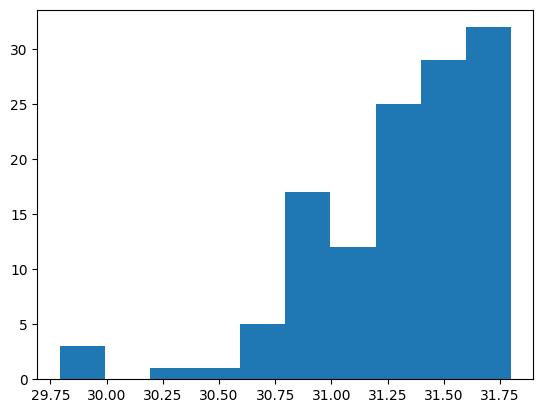

In [125]:
plt.figure()
plt.hist(mock["mu_calibration"][0, m], bins="auto")
plt.show()

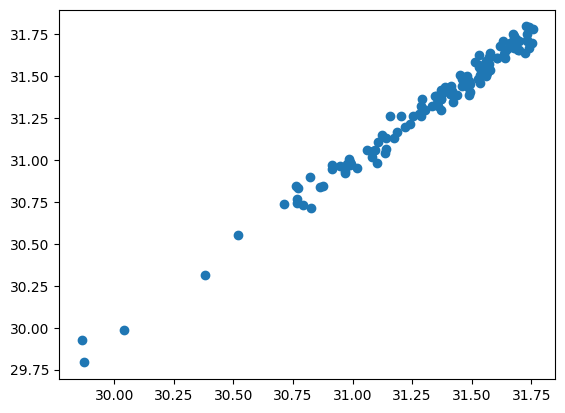

In [126]:
plt.figure()
# plt.hist(mock["mu_TFR"] - mock["mu_calibration"][1])
plt.scatter(mock["mu_true"], mock["mu_calibration"][0])
plt.show()


In [127]:
np.sum(np.isfinite(mock["mu_calibration"]), axis=1)

array([125])

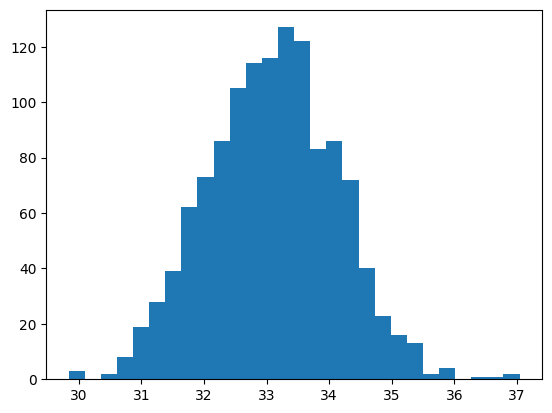

In [10]:
m = np.isfinite(mock["mu_calibration"])

plt.figure()
plt.hist(mock["mu_calibration"][m], bins="auto")
plt.show()

In [101]:
np.percentile(mock["mu_true"], 10)

31.757872992956177

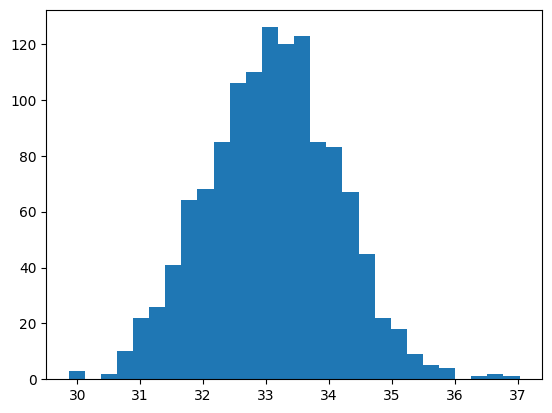

In [75]:
plt.figure()
plt.hist(mock["mu_true"], bins="auto")
plt.show()

In [57]:
from jax import numpy as jnp
from jax.scipy.special import logsumexp

def normal_logpdf(x, loc, scale):
    """Log of the normal probability density function."""
    return (-0.5 * ((x - loc) / scale)**2
            - jnp.log(scale) - 0.5 * jnp.log(2 * jnp.pi))

In [44]:
mu_true = np.copy(mock["mu_true"])
mu_calibration = np.copy(mock["mu_calibration"])
e_mu = np.copy(mock["e_mu_calibration"])

mu_calibration = np.stack([mu_calibration, mu_calibration])
e_mu_calibration = np.stack([e_mu, e_mu])

mu_calibration[0, 100:] = np.nan
e_mu_calibration[0, 100:] = np.nan

mu_calibration[1, 50:] = np.nan
e_mu_calibration[1, 50:] = np.nan

In [105]:

h = 0.7

# Now, the rest of the code except the calibration likelihood
# uses the distance modulus in units of h
mu_true_h = mu_true + 5 * jnp.log10(h)

# Calculate the log-likelihood of the calibration, but the
# shape is `(n_calibrators, n_data)`.
ll_calibration = normal_logpdf(
    mu_calibration, mu_true[None, :],
    e_mu_calibration)

# Create a mask for valid (non-NaN) log-likelihoods
calibration_mask = ~jnp.isnan(ll_calibration)

# Replace NaN values with zero (or another neutral value) for safety
ll_calibration_clean = jnp.where(calibration_mask, ll_calibration, 0.0)

# Count the number of valid calibrators for each galaxy (non-NaN entries)
counts = jnp.sum(calibration_mask, axis=0)

# Now apply logsumexp only to the valid log-likelihoods
ll_calibration_sum = jnp.where(
    counts > 0,
    logsumexp(ll_calibration_clean, axis=0) - jnp.log(counts),
    0.0  # Return zero likelihood if no valid calibrators
)

In [120]:
from jax.lax import cond
def ll_calibration(mu_calibration, mu_true, e_mu):
    # Use jnp.where to apply element-wise conditional logic
    return jnp.where(
        jnp.isfinite(mu_calibration),  # Check for finite values
        normal_logpdf(mu_calibration, mu_true, e_mu),  # Use valid values
        0.0  # Return 0 for invalid (non-finite) values
    )


In [121]:
mu_calibration[0, 0]

33.15014277245038

In [127]:
ll_calibration(mu_calibration, mu_true[None, :], e_mu)

Array([[1.5757915, 1.3846258, 2.0763617, ..., 0.       , 0.       ,
        0.       ],
       [1.5757915, 1.3846258, 2.0763617, ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [125]:
mu_calibration[0], mu_true

(array([33.15014277, 33.36291487, 31.68284461, ...,         nan,
                nan,         nan]),
 array([33.10009268, 33.30408597, 31.68137438, ..., 31.3564011 ,
        32.63194483, 33.72852162]))

In [69]:
ll = normal_logpdf(mu_calibration, mu_true[None, :], e_mu)

print(ll)
print()


mask = ~jnp.isnan(ll)
ll = jnp.where(mask, ll, -jnp.inf)

print(ll)
print()

counts = jnp.sum(mask, axis=0)
ll = jnp.where(counts > 0, logsumexp(ll, axis=0) - jnp.log(counts), 0.)

print(ll)
print()

[[1.5757915 1.3846258 2.0763617 ...       nan       nan       nan]
 [1.5757915 1.3846258 2.0763617 ...       nan       nan       nan]]

[[1.5757915 1.3846258 2.0763617 ...      -inf      -inf      -inf]
 [1.5757915 1.3846258 2.0763617 ...      -inf      -inf      -inf]]

[1.5757914 1.3846259 2.0763617 ... 0.        0.        0.       ]



In [68]:
jnp.sum(~jnp.isnan(ll))

Array(100, dtype=int32)